This notebook contains the first task in DELTA. Additionally, the notebook shows how to import the provided data.

### **1. Description of the notebook**

The jupyter notebook contains the following elements:

- Preprocessing of your datasets according to the requirements of neural networks.
- Implementation of 3 benchmark models: a linear model, a tree-based model and a neural network that has not been tuned. 
- Tuning of a neural network using a hyperparameter optimization library(see code). The hyperparameter tuning includes regularization. 
- A well annotated plot showing the train vs. validation loss of the best performing neural network. Interpretation of the plot tested with specific data (not provided in the repo).
- A table showing all results (on a validation subset) from the tuned network and your benchmarks.

### **2. Data Import**

So that you can import the data with the code cell below, you should put the data in the same folder of the notebook. Otherwise, you would have to adjust the file path.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras_tuner
import keras


#Predictor features on the train set:
train_X=pd.read_csv('train_X.csv',sep=',',header=0,index_col=0)
#Target variable on the train set:
train_y=pd.read_csv('train_y.csv',sep=',',header=0,index_col=0)
#Predictor features on the test set:
test_X=pd.read_csv('test_X.csv',sep=',',header=0,index_col=0)
#Demo predictions file:
demo_predictions=pd.read_csv('Demo_Predictions.csv',sep=',',header=0,index_col=0)

## **3. Preprocess of datasets**

In [2]:
#Split the training set into train and validation with the ratio 80:20.
x_train, x_val, y_train, y_val=train_test_split(train_X,train_y,test_size=0.2)

#Only the input features (X) are rescaled; the target variable (y) remains in original scale to directly predict real-world values:
scaler=StandardScaler()
x_train_rescaled=scaler.fit_transform(x_train)
x_val_rescaled=scaler.transform(x_val)
x_test_rescaled=scaler.transform(test_X)

## **4. Benchmark Models(Linear Regression & Random Forest)**

In [3]:
results = {}

#Linear Regression
linear_model = LinearRegression()
linear_model.fit(x_train_rescaled, y_train)
pred_linear = linear_model.predict(x_val_rescaled)
mse_lr = mean_squared_error(y_val, pred_linear)
mae_lr = mean_absolute_error(y_val, pred_linear)
rmse_lr = np.sqrt(mse_lr)
results["Linear Regression"] = {"MSE": mse_lr, "MAE": mae_lr, "RMSE": rmse_lr}

#Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train_rescaled, y_train.values.ravel())
pred_rf = rf_model.predict(x_val_rescaled)
mse_rf = mean_squared_error(y_val, pred_rf)
mae_rf = mean_absolute_error(y_val, pred_rf)
rmse_rf = np.sqrt(mse_rf)
results["Random Forest"] = {"MSE": mse_rf, "MAE": mae_rf, "RMSE": rmse_rf}

## **4.1. Benchmark Models(Untuned DNN)**

In [4]:
#Define your early stopping callback:
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min'
)

#Your keras model using the sequential api:
model = keras.Sequential()
model.add(keras.Input(shape=(x_train_rescaled.shape[1],)))
model.add(keras.layers.Dense(units=100, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(units=50, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(units=10, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(units=1, activation='linear'))

model.compile(optimizer=keras.optimizers.Adam(), loss='mse')

#Train your model:
model_training_history = model.fit(
    x=x_train_rescaled,
    y=y_train,
    validation_data=(x_val_rescaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es_callback],
    verbose=0
)

2025-05-30 15:41:13.675061: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-30 15:41:13.675087: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-30 15:41:13.675095: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-30 15:41:13.675114: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-30 15:41:13.675124: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-30 15:41:14.162697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-30 15:41:14.164809: E t

Epoch 16: early stopping


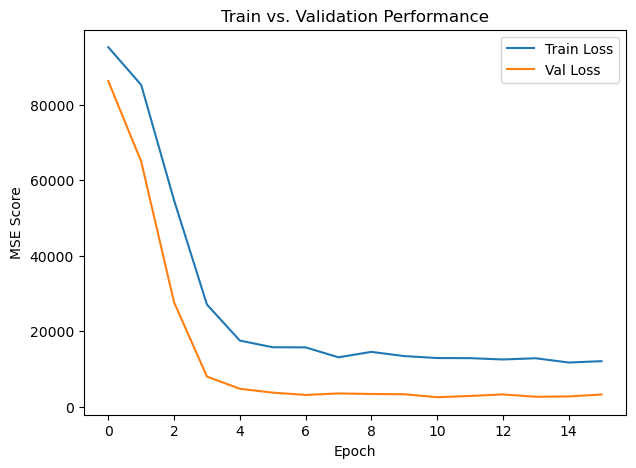

In [5]:
#Create a function to visualize the model performance
def visualize_performance(train_loss_list: list,
                          val_loss_list: list) -> None:
    '''
    Visualizes the training vs. validation performance of a feedforward neural network.

    Parameters:
    -----------
    train_loss_list : list
        List of epoch train loss values.
    val_loss_list : list
        List of epoch val loss values.

    Returns:
    --------
    None
    '''

    plt.figure(figsize=(7, 5))
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(val_loss_list, label='Val Loss')
    plt.ylabel('MSE Score')
    plt.xlabel('Epoch')
    plt.title('Train vs. Validation Performance')
    plt.legend()
    plt.show()
    plt.close()

#Visualize the performance by calling the function
#You can access the training history by calling model_training_history.history...

train_loss = model_training_history.history['loss']
val_loss = model_training_history.history['val_loss']

visualize_performance(train_loss_list=train_loss,
                      val_loss_list=val_loss)

In [6]:
val_pr = model.predict(x_val_rescaled, verbose=0)
print('Test MSE achieved by not tuned Keras Sequential Model: ',
      round(mean_squared_error(y_true=y_val.values.flatten(), y_pred=val_pr.flatten()), 5))

Test MSE achieved by not tuned Keras Sequential Model:  3180.91225


## **5. Hyperparameter Tuning with Keras Tuner**

In [7]:
def keras_hp_optimization(hp: keras_tuner.HyperParameters) -> keras.Sequential:
    '''
    Perform hyperparameter tuning using keras_tuner.

    Parameters:
    -----------
    hp : keras_tuner.HyperParameters
        A set of different types of keras tuner hyperparameters, which can be sampled during the search.

    Returns: 
    --------
    model : keras.Sequential
        The keras model built with the sequential API and the set of sampled hyperparameters in the current trial.
    '''

    # Sample the type of activation function to apply in each hidden layer:
    current_activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    model = keras.Sequential()
    model.add(keras.Input(shape=(x_train_rescaled.shape[1],)))
    
    # Sample L2 regularization strength (weight decay)
    l2_strength = hp.Float('l2_strength', min_value=1e-5, max_value=1e-2, sampling='log')

    # Sample number of neurons for up to 3 hidden layers
    max_hidden_layers = 3
    keep_sampling_hidden_units = True
    nr_hidden_layer = 0

    while keep_sampling_hidden_units:
        units_name = f'units_layer_{nr_hidden_layer}'
        current_hidden_units = hp.Int(units_name, min_value=0, max_value=128, step=32)

        if current_hidden_units == 0 or nr_hidden_layer == max_hidden_layers - 1:
            keep_sampling_hidden_units = False

        if current_hidden_units != 0:
            model.add(keras.layers.Dense(
                units=current_hidden_units,
                activation=current_activation,
                kernel_initializer='he_normal',
                kernel_regularizer=keras.regularizers.l2(l2_strength)
            ))

        nr_hidden_layer += 1

    # Output layer
    model.add(keras.layers.Dense(units=1, activation='linear'))

    # Non-conditional hyperparameters
    current_optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    current_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    if current_optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=current_learning_rate)
    elif current_optimizer == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=current_learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=current_learning_rate)

    model.compile(optimizer=optimizer, loss='mse')
    return model

In [8]:
#Define early stopping callback
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

#Initialize Keras Tuner with RandomSearch
tuner = keras_tuner.RandomSearch(
    keras_hp_optimization,
    objective='val_loss',
    max_trials=50,
    overwrite=True,
    directory='./tmp/checkpoint',
    project_name='dnn_tuning'
)

#Launch search
tuner.search(x_train_rescaled, y_train,
             validation_data=(x_val_rescaled, y_val),
             epochs=100,
             batch_size=32,
             callbacks=[es_callback],
             verbose=1)

#Retrieve the best performing model
best_model = tuner.get_best_models(num_models=1)[0]

#Predict with best model
tuned_keras_pr = best_model.predict(x_val_rescaled, verbose=0)

#Compare with untuned model predictions (val_pr)
print('Test MSE achieved by not tuned Keras Sequential Model: ',
      round(mean_squared_error(y_val.values.flatten(), val_pr.flatten()), 4))
print('Test MSE achieved by tuned Keras Sequential Model: ',
      round(mean_squared_error(y_val.values.flatten(), tuned_keras_pr.flatten()), 4))

#Print best hyperparameters
print('Best hyperparameter configuration found:\n', tuner.get_best_hyperparameters(1)[0].values)

Trial 50 Complete [00h 00m 40s]
val_loss: 30465.306640625

Best val_loss So Far: 56.29609298706055
Total elapsed time: 00h 17m 10s
Test MSE achieved by not tuned Keras Sequential Model:  3180.9122
Test MSE achieved by tuned Keras Sequential Model:  56.2689
Best hyperparameter configuration found:
 {'activation': 'relu', 'l2_strength': 1.4477980168817606e-05, 'units_layer_0': 96, 'optimizer': 'adam', 'learning_rate': 0.006416198367381452, 'units_layer_1': 0, 'units_layer_2': 64}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
#Compare with untuned model predictions (val_pr)
print('Test MSE achieved by not tuned Keras Sequential Model: ',
      round(mean_squared_error(y_val.values.flatten(), val_pr.flatten()), 4))
print('Test MSE achieved by tuned Keras Sequential Model: ',
      round(mean_squared_error(y_val.values.flatten(), tuned_keras_pr.flatten()), 4))

#Print best hyperparameters
print('Best hyperparameter configuration found:\n', tuner.get_best_hyperparameters(1)[0].values)

Test MSE achieved by not tuned Keras Sequential Model:  3180.9122
Test MSE achieved by tuned Keras Sequential Model:  56.2689
Best hyperparameter configuration found:
 {'activation': 'relu', 'l2_strength': 1.4477980168817606e-05, 'units_layer_0': 96, 'optimizer': 'adam', 'learning_rate': 0.006416198367381452, 'units_layer_1': 0, 'units_layer_2': 64}


Restoring model weights from the end of the best epoch: 100.


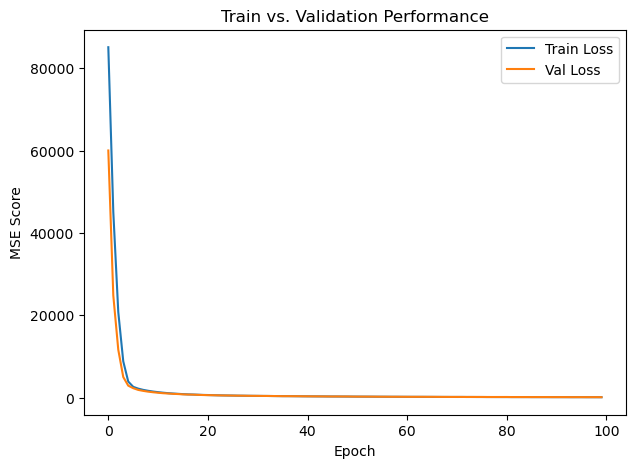

In [10]:
#Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

#Rebuild the model using the best hyperparameters
model = keras_hp_optimization(best_hp)

#Retrain the model and save the history
model_training_history = model.fit(
    x_train_rescaled, y_train,
    validation_data=(x_val_rescaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es_callback],
    verbose=0
)

#Now you can visualize the loss curves
train_loss = model_training_history.history['loss']
val_loss = model_training_history.history['val_loss']

visualize_performance(train_loss_list=train_loss,
                      val_loss_list=val_loss)

## Interpretation of the plot ##

**The model shows rapid convergence within the first 10 epochs, with both training and validation loss decreasing sharply and stabilizing. The close overlap between the two curves suggests the model generalizes well with no signs of overfitting**

In [11]:
tuned_val_pr = best_model.predict(x_val_rescaled, verbose=0)
print('Test MSE achieved by tuned Keras Sequential Model: ',
      round(mean_squared_error(y_true=y_val.values.flatten(), y_pred=tuned_val_pr.flatten()), 5))

Test MSE achieved by tuned Keras Sequential Model:  56.26892


In [12]:
print('Test MSE achieved by not tuned Keras Sequential Model: ',
      round(mean_squared_error(y_val.values.flatten(), val_pr.flatten()), 5))

print('Test MSE achieved by tuned Keras Sequential Model: ',
      round(mean_squared_error(y_val.values.flatten(), tuned_val_pr.flatten()), 5))

Test MSE achieved by not tuned Keras Sequential Model:  3180.91225
Test MSE achieved by tuned Keras Sequential Model:  56.26892


## **6.Table showing all results (on a validation subset) of benchmarks & Tuned DNN** ##

In [13]:
#Untuned DNN
mse_untuned = mean_squared_error(y_val.values.flatten(), val_pr.flatten())
mae_untuned = mean_absolute_error(y_val.values.flatten(), val_pr.flatten())
rmse_untuned = np.sqrt(mse_untuned)
results["Untuned DNN"] = {"MSE": mse_untuned, "MAE": mae_untuned, "RMSE": rmse_untuned}

#Tuned DNN
mse_tuned = mean_squared_error(y_val.values.flatten(), tuned_val_pr.flatten())
mae_tuned = mean_absolute_error(y_val.values.flatten(), tuned_val_pr.flatten())
rmse_tuned = np.sqrt(mse_tuned)
results["Tuned DNN"] = {"MSE": mse_tuned, "MAE": mae_tuned, "RMSE": rmse_tuned}


#Display Table
results_df = pd.DataFrame(results).T
display(results_df)

,MSE,MAE,RMSE
Linear Regression,1173.126302,26.690004,34.250931
Random Forest,628.667526,15.131417,25.073243
Untuned DNN,3180.912247,41.430615,56.399577
Tuned DNN,56.268917,5.682313,7.501261


## Iterpretation of the suitability of the best-performing model for the task ##

**The model’s relatively low complexity makes it efficient, while still achieving the best performance across all benchmarks. Evaluation metrics such as MSE, RMSE, and MAE are consistently lower than those of Linear Regression, Random Forest, and the untuned DNN. This confirms that the tuned architecture is well-suited for the task.**

## **7.Usage and predition of target using our X_test.cvs**

In [14]:
#Predict using the best model
y_test_predictions = best_model.predict(x_test_rescaled, verbose=0)

#Create DataFrame with default index and same column name as train_y
predicted_df = pd.DataFrame(y_test_predictions)

#Show result
display(predicted_df.head())

,0
0,-221.092636
1,-222.288925
2,-197.037872
3,-238.316788
4,-167.754135


## Save predictions to CSV ##

In [15]:
#Save to CSV
predicted_df.to_csv("predictions_on_testset.csv", index=True, header=True)